In [1]:
import sys

import pandas as pd

sys.path.append('../../../Fedot.Industrial')
import os
from core.architecture.postprocessing.cv_results_parser import *

In [70]:
exp_root = 'summary/FashionMNIST'
exps = os.listdir(exp_root)
for exp in exps:
    create_mean_exp(os.path.join(exp_root, exp))

In [3]:
from typing import Dict

def exp_list(config: Dict, folds = [0, 1],  n = [0, 1, 2, 3, 4]):
    pruning_ratio = [p['pruning_ratio'] for p in config['sfp_params']['zeroing']['percentage']]
    energy_threshold = [e['energy_threshold'] for e in config['sfp_params']['zeroing']['energy']]
    hoer_loss_factor = config['svd_params']['hoer_loss_factor']
    orthogonal_loss_factor = config['svd_params']['orthogonal_loss_factor']
    root = f"summary/{config['ds_name']}/{config['model_name']}"
    exps = {'Baseline': f"{root}/mean"}
    sfp_exps = {
        'energy': {f'SFP energy {e}': f'{root}_SFP_energy_threshold-{e}/mean' for e in energy_threshold},
        'percentage': {f'SFP {pr * 100}%': f'{root}_SFP_pruning_ratio-{pr}/mean' for pr in pruning_ratio},
    }

    svd_exps = {
        'channel': {f'Hoer {hoer} Ort {ort}': f'{root}_SVD_channel_O-{ort}_H-{hoer}/mean' for hoer in hoer_loss_factor for ort in orthogonal_loss_factor},
        'spatial': {f'Hoer {hoer} Ort {ort}': f'{root}_SVD_spatial_O-{ort}_H-{hoer}/mean' for hoer in hoer_loss_factor for ort in orthogonal_loss_factor},
    }
    return exps, sfp_exps, svd_exps

In [4]:
from exp_parameters import TASKS
ds_name = 'FashionMNIST'
baseline, sfp_exps, svd_exps = exp_list(TASKS[ds_name])
get_best_metric(
    exp_path=baseline['Baseline'],
    metric='f1'
)

0.8991650277793779

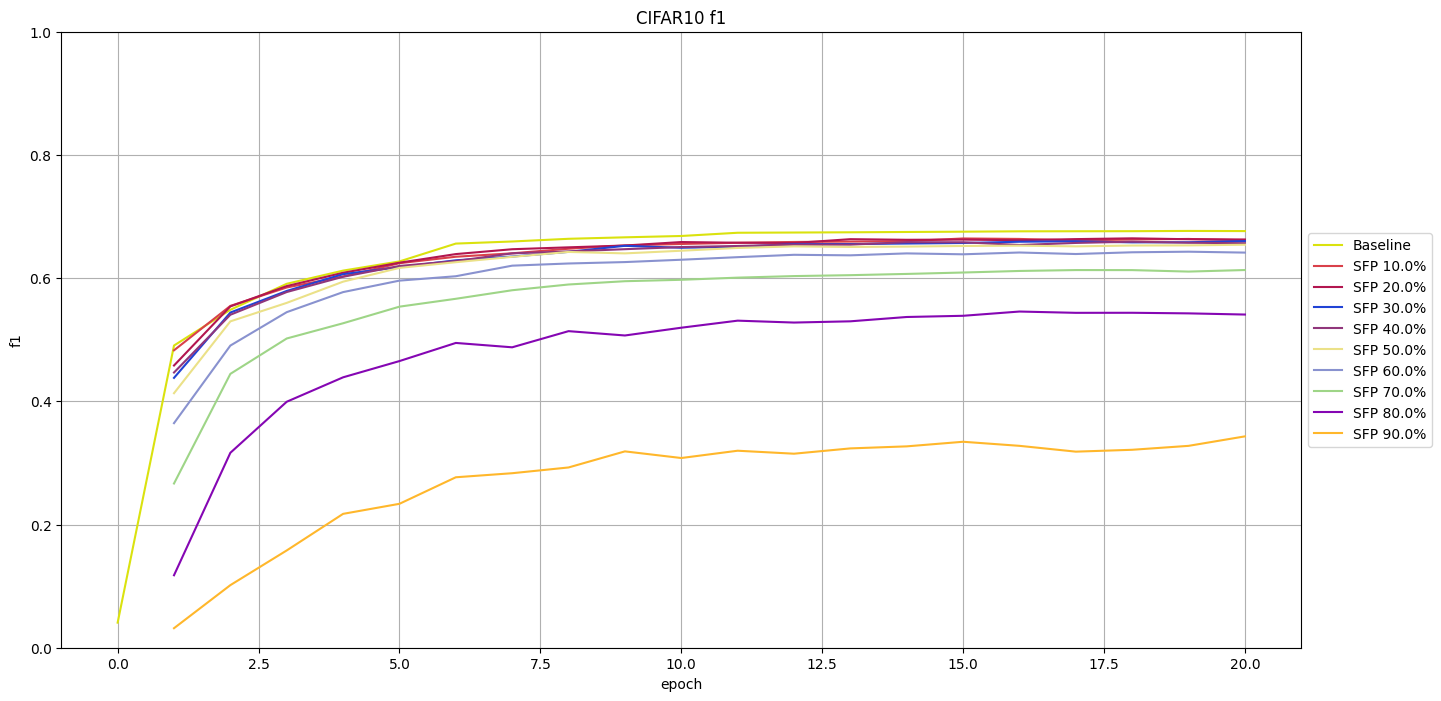

In [102]:
exps = {**baseline}
exps.update(sfp_exps['percentage'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=False,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0, 1),
    # saving_path='f1.png'
)

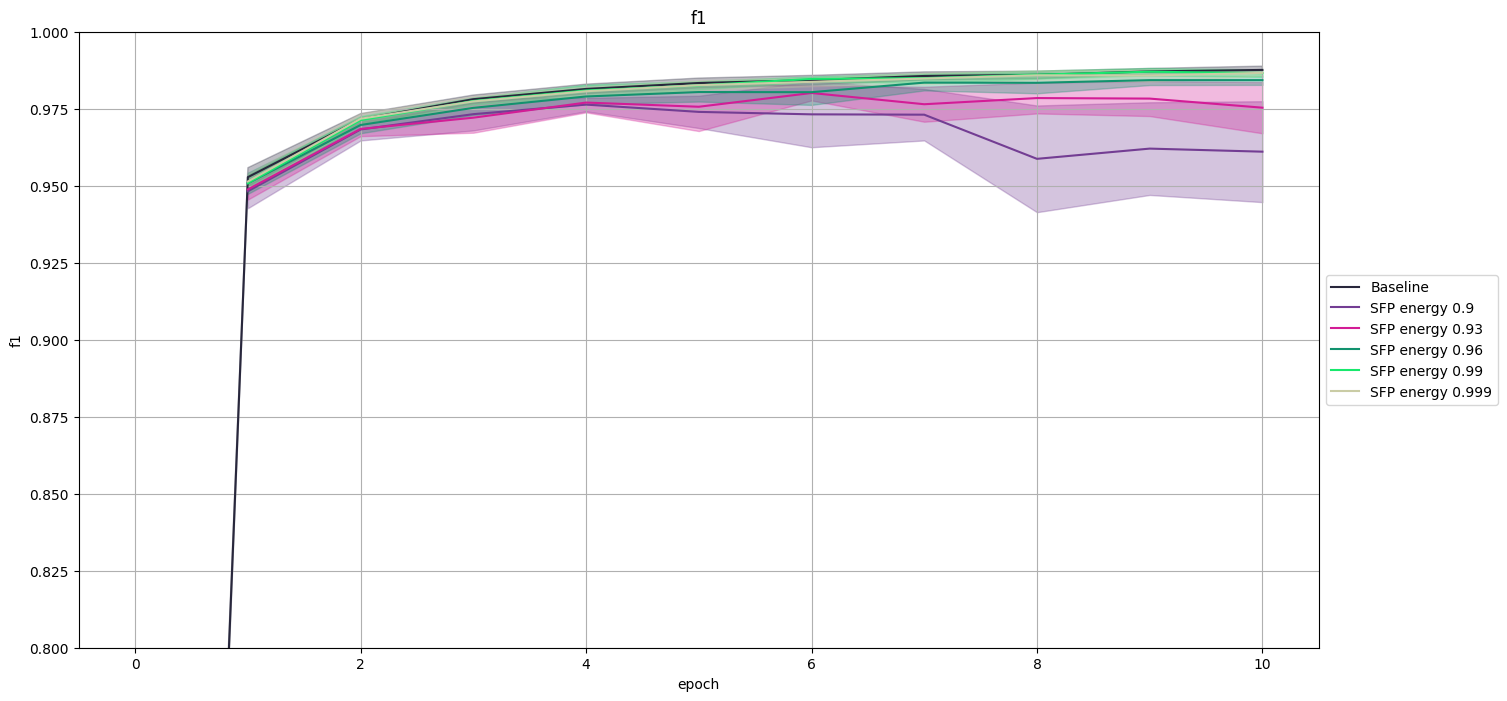

In [5]:
exps = {**baseline}
exps.update(sfp_exps['energy'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=True,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0.8, 1),
    # saving_path='f1.png'
)

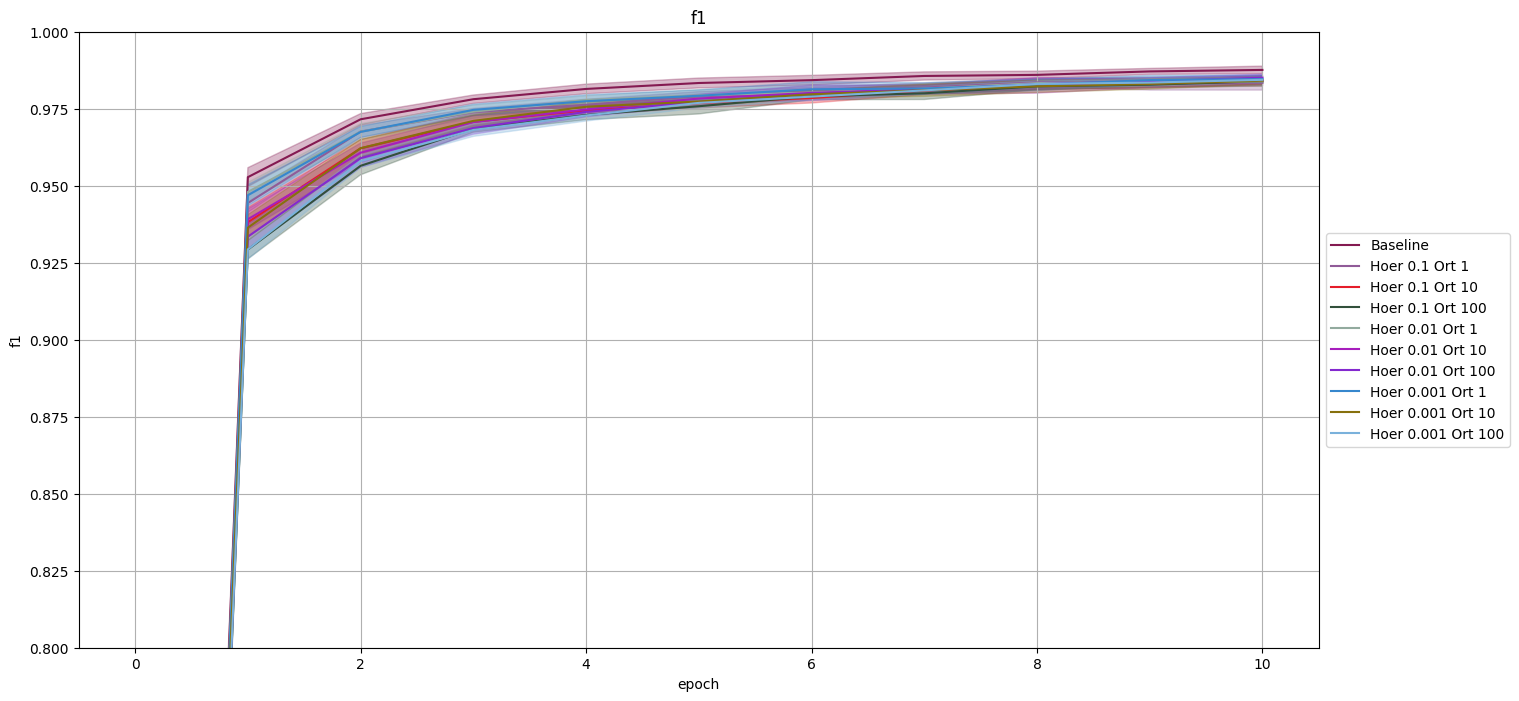

In [8]:
exps = {**baseline}
exps.update(svd_exps['channel'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=True,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0.8, 1),
    # saving_path='f1.png'
)

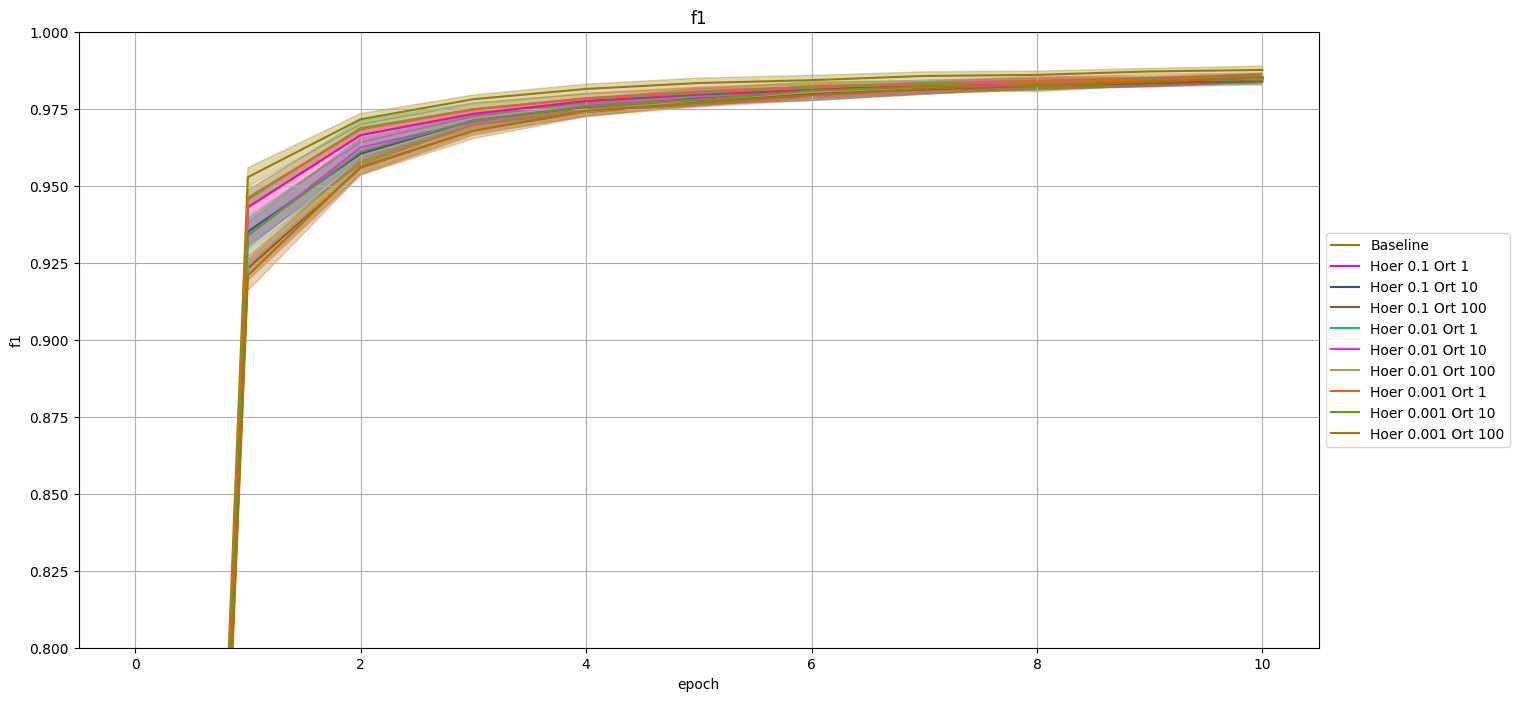

In [9]:
exps = {**baseline}
exps.update(svd_exps['spatial'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=True,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0.8, 1),
    # saving_path='f1.png'
)

In [5]:
svd_channel = compare_svd_results(
    baseline=baseline['Baseline'],
    svd_exps=svd_exps['channel'],
    metric='f1'
)
svd_spatial = compare_svd_results(
    baseline=baseline['Baseline'],
    svd_exps=svd_exps['spatial'],
    metric='f1'
)

In [205]:
sfp_energy = compare_sfp_results(
    baseline=baseline['Baseline'],
    sfp_exps=sfp_exps['energy'],
    metric='f1'
)
sfp_per = compare_sfp_results(
    baseline=baseline['Baseline'],
    sfp_exps=sfp_exps['percentage'],
    metric='f1'
)

In [208]:
sfp_per.loc[sfp_per['fine-tuned']>=97]['size'].min()

4.248640426270877

In [211]:
sfp_energy.loc[sfp_energy['fine-tuned']>=97]['size'].min()

18.40018728485322

In [8]:
df = svd_channel['Hoer 0.1 Ort 10']
df.loc[df['fine-tuned']>=97]

,pruned,pruned std,fine-tuned,fine-tuned std
size,,,,
51.017471,91.502424,3.792748,97.223025,0.314346
77.323146,96.780029,0.496346,98.361199,0.314346
82.926436,97.014669,0.426090,98.371989,0.314346
89.546911,97.312552,0.409875,98.592600,0.314346
98.788320,97.663220,0.360334,98.415116,0.314346
103.355850,97.749330,0.347360,98.670968,0.314346


In [10]:
df = svd_spatial['Hoer 0.1 Ort 1']
df.loc[df['fine-tuned'] >= 99]

,pruned,pruned std,fine-tuned,fine-tuned std
size,,,,
35.844145,98.522696,0.355797,99.335625,0.285404
38.630161,98.574696,0.332927,99.377616,0.285404
42.060353,98.634310,0.369301,99.483282,0.285404
48.407353,98.817322,0.300107,99.479735,0.285404
54.555814,98.853501,0.268240,99.543672,0.285404


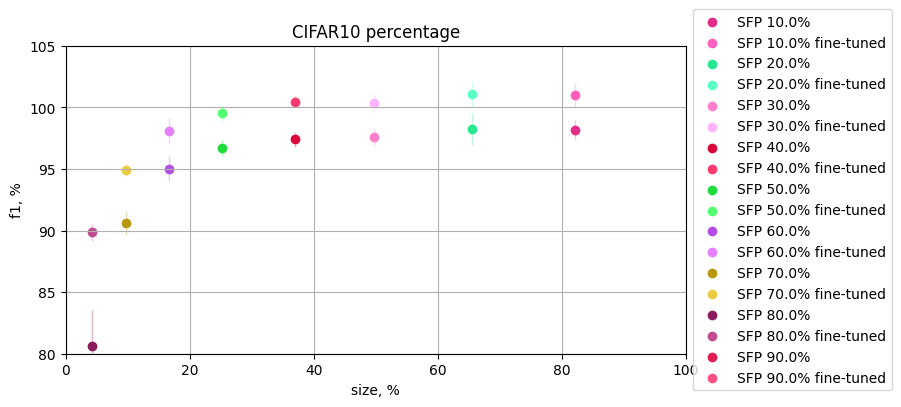

In [111]:
ax = show_sfp_results(
    sfp_exps=sfp_per,
    figsize=(8, 4),
    title=f'{ds_name} percentage',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(80, 105),
    xlim=(0, 100)
)

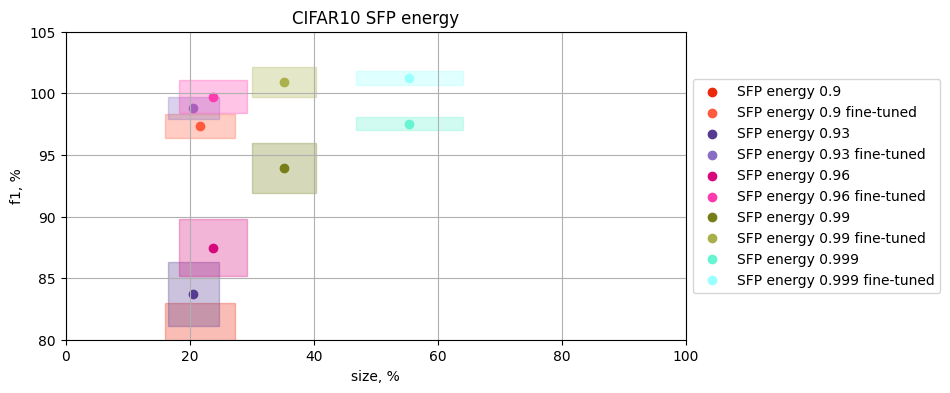

In [118]:
ax = show_sfp_results(
    sfp_exps=sfp_energy,
    figsize=(8, 4),
    title=f'{ds_name} SFP energy',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(80, 105),
    xlim=(0, 100)
)

In [27]:
channel_exps = {k: v for k, v in svd_channel.items() if 'Hoer 0.1' in k}

In [127]:
channel_exps = {k: v for k, v in svd_channel.items() if k.endswith('Ort 10')}

In [132]:
channel_exps = {k: v[['pruned', 'fine-tuned']] for k, v in svd_channel.items() if 'Hoer 0.1' in k }

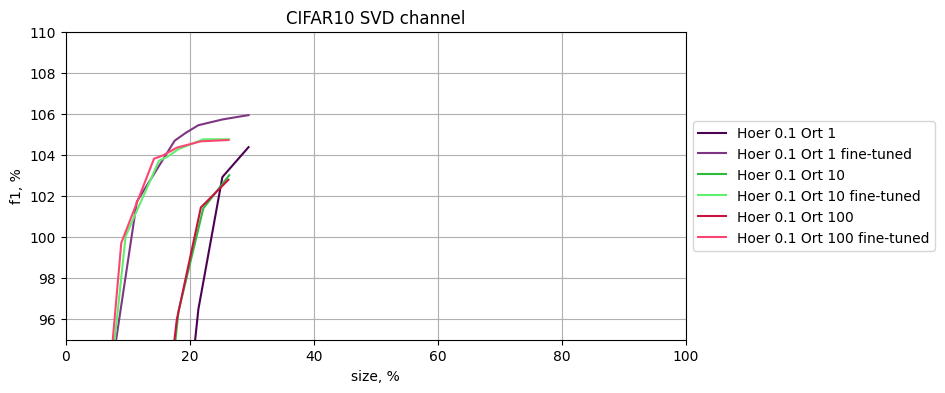

In [142]:
ax = show_svd_results(
    svd_exps=channel_exps,
    figsize=(8, 4),
    title=f'{ds_name} SVD channel',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(95, 110),
    xlim=(0, 100)
)

In [34]:
spatial_exps = {k: v for k, v in svd_spatial.items() if 'Hoer 0.1' in k}

In [36]:
spatial_exps = {k: v for k, v in svd_spatial.items() if k.endswith('Ort 10')}

In [134]:
spatial_exps = {k: v[['pruned', 'fine-tuned']] for k, v in svd_spatial.items() if 'Hoer 0.1' in k }

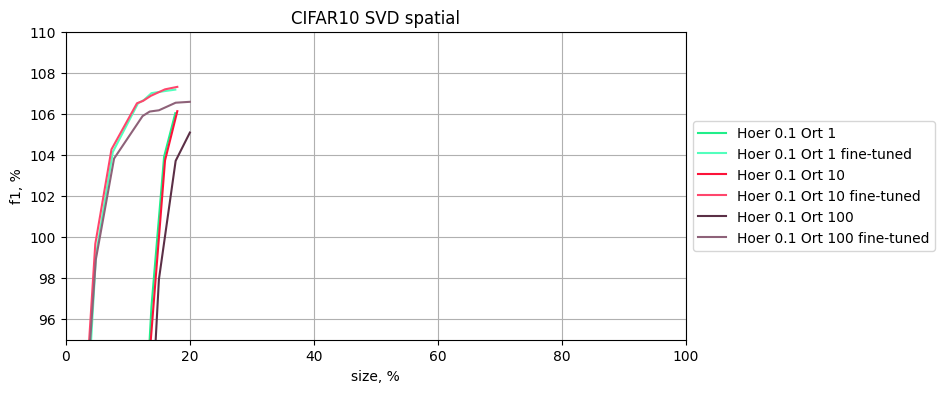

In [147]:
ax = show_svd_results(
    svd_exps=spatial_exps,
    figsize=(8, 4),
    title=f'{ds_name} SVD spatial',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(95, 110),
    xlim=(0, 100)
)

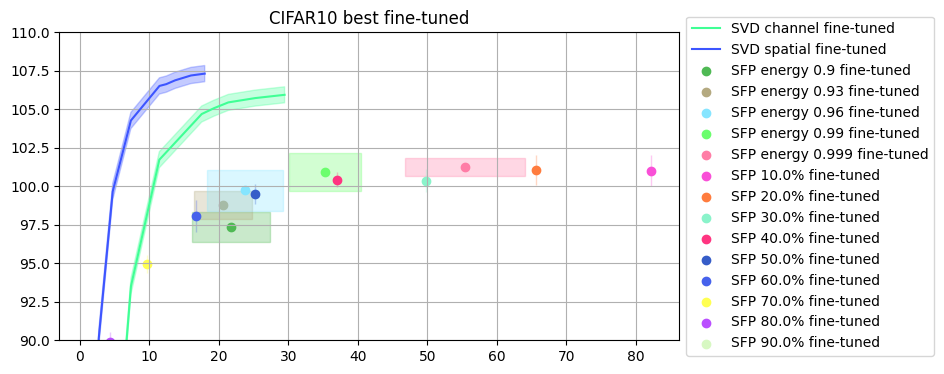

In [159]:
ax = show_svd_sfp_results(
    sfp_exps=pd.concat([sfp_energy, sfp_per])[['size', 'size std', 'fine-tuned', 'fine-tuned std']],
    svd_exps={
        'SVD channel': svd_channel['Hoer 0.1 Ort 1'][['fine-tuned', 'fine-tuned std']],
        'SVD spatial': svd_spatial['Hoer 0.1 Ort 10'][['fine-tuned', 'fine-tuned std']],
    },
    figsize=(8, 4),
    title=f'{ds_name} best fine-tuned',
    ylim=(90, 110)
)